# Data Mining 2026  — Project Notebook

**Course:** Data Mining  

**Project track:** Track A

**Group members:**  
- Rahul
- Thorkild
- Diago
- Ramesh

**Dataset:**   Twenty Newsgroups https://huggingface.co/datasets/mteb/twentynewsgroups-clustering

**Initial task description (Module 1 perspective):**
The dataset we have chosen to look into is the "MTEB - 20 news groups" dataset. It includes around 55.000 texts from 20 different categories of news. However, this dataset poses some challenges that makes clustering specifically hard. The main reason for this is that some news groups are semantically similar, eg. one is about motorcycles whereas a different one is about cars. Where as, in another place in the semantic spectrum we have one group about ms-windows.misc and another is windows.x. Thus if a goal was made to try to cluster the data into these "true" groups, it might become a hard task. However, this is not what we intend to do. Instead we want to use DBScan, together with the heuristic method for determining the epsilon parameter, as a method of to see how clusters "naturally" arise in this data. As an example, it would be interesting if we got less than 20 clusters, to see if some of the true groups like the two windows ones were hard to seperate. Thus, once clustered, we want to analyse whether we can see a clear trend in these clusters. Essentially this can be seen as a kind of topic modelling. The clustering will be based on dimensionality reduced embedding vectors.

For evaluation we intend to to compare with k-means and the elbow method to see how clusters naturally arise, and then we will compare the two methods using Internal evaluation methods. Although external evaluation methods might seem straight forward since we have the true labels, it is important to remember that we are not trying to replicate the true labels, we are trying to make natural clusters from all the data. Thus we will be evaluating the true clusters with TD and Silhouette coefficient. However, it will still be important to look at, and analyse, the data seperated into the true labels to understand the data and how it is "intended" to be clustered.

Lastly we can make a word cloud and maybe other word-statistics for each cluster to analyze what type of words the clusters actually contain, and if it makes sense, see if we can visualize the data using TSNE.

## 0. Reproducibility and Setup

In [1]:
from datasets import load_dataset
import plotly.express as px
from itertools import chain
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from src.DBScan import DBScan
import numpy as np
from src.NearestNeighbours import NearestNeighbours
from scipy.spatial import distance_matrix

## 1. Dataset Description and Loading

### 1.1 Dataset Overview

- Source: https://huggingface.co/datasets/mteb/twentynewsgroups-clustering
- Number of instances: 10
- Number of features / entities: 2 ("sentences" and "labels")
- Missing values: 0
- Basic statistics: 
    - Total unique groups: 20
    - Total Number of texts:  59545
    - Total number of labels: 59545


In [2]:
# Load dataset
dataset = load_dataset("mteb/twentynewsgroups-clustering", revision="6125ec4e24fa026cec8a478383ee943acfbd5449")
print(dataset["test"])

# Extracting variables
test = dataset["test"]
texts_sep = list(test["sentences"])
labels_sep = list(test["labels"])

total = set()
for i in range(len(test)):
    total = total.union(set(test[i]["labels"]))
print("Total unique groups:", len(total))

texts = []
for text in texts_sep:
    texts.extend(text)
print("Total Number of texts: ", len(texts))

labels_list = list(chain.from_iterable(labels_sep))
label_counts = OrderedDict(sorted(Counter(labels_list).items()))
print("Total number of labels:", len(labels_list))

px.bar(x=[str(_) for _ in label_counts.keys()], y=label_counts.values(), labels={"x": "labels", "y": "count of appearance"})

Dataset({
    features: ['sentences', 'labels'],
    num_rows: 10
})
Total unique groups: 20
Total Number of texts:  59545
Total number of labels: 59545


### 1.2 - Data Preprocessing

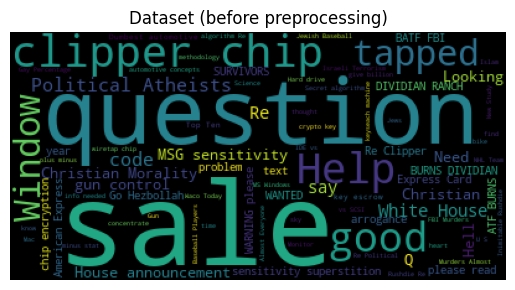

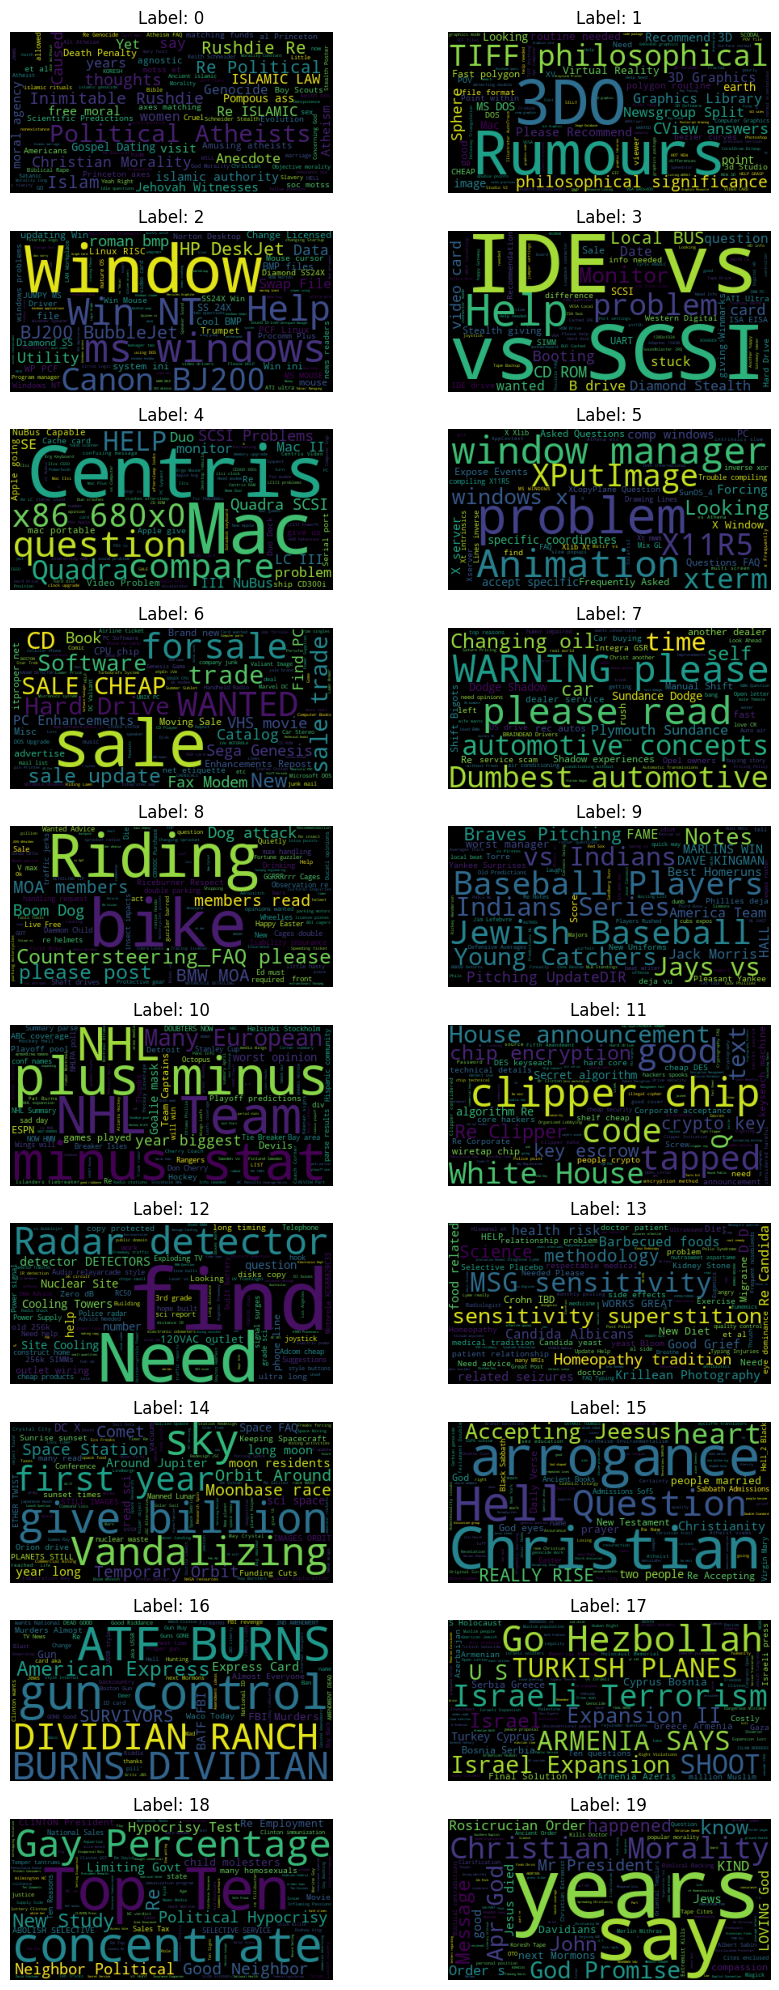

In [3]:
get_from = lambda x: [texts[i] for i, val in enumerate(labels_list) if val == x]
get_word_cloud = lambda x: WordCloud(stopwords=STOPWORDS, max_words=100).generate(x) 

# Before preprocessing

cloud = get_word_cloud(" ".join(texts))
plt.title("Dataset (before preprocessing)")
plt.axis("off")
plt.imshow(cloud)

# Word clouds for each label

fig, _axs = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

for _ in range(20):
    axs[_].imshow(get_word_cloud(" ".join(get_from(_))))
    axs[_].set_title(f"Label: {_}")
    axs[_].axis("off")
fig.tight_layout()
plt.show()

### Exploratory Data Analysis
- Basic statistics
- Distributions
- Sparsity / density

### Cleaning & Transformations
- Handling missing values
- Feature engineering
- Graph construction (if Checkpoint 2)

Justify design decisions.

## 2. Module 1 — Vector-Space Analysis

In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(texts)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Sample embeddings[0][0:20]: {embeddings[0][0:20]}")

# Dimensionality reduction using PCA

pca = PCA(n_components=2 ** 6)  #64

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embeddings shape: (59545, 384)
Sample embeddings[0][0:20]: [-0.10949051  0.01752549  0.06833325 -0.0504889   0.01307427 -0.01668743
 -0.02064353  0.03873769 -0.03209924  0.016407    0.10264194  0.01111447
  0.07978289 -0.01114768 -0.04782147  0.01050704  0.01809989 -0.02259755
  0.08697542  0.01350243]


### 2.1 Vector Representation

Explain your feature construction and distance measure here.

In [5]:
features = pca.fit_transform(embeddings)
print(f"Features shape: {features.shape}")

test_features = features[0:10000]
print(f"Test features shape: {test_features.shape}")
print(f"Test features[9]: {test_features[9]}")

Features shape: (59545, 64)
Test features shape: (10000, 64)
Test features[9]: [-0.03578572 -0.03294921 -0.2135972   0.06858742  0.09796464  0.05993736
  0.1594515   0.24713874 -0.1793809  -0.11295338  0.2899509  -0.08548094
 -0.09517146 -0.10904061 -0.01815843  0.06955553  0.24568927  0.04191928
  0.09513504 -0.06501768  0.01594953  0.09525616 -0.06524366 -0.06739256
  0.04816995 -0.03976784  0.07842852 -0.08184901 -0.04945645 -0.0026669
  0.09293792 -0.09974931  0.01910411 -0.13573934 -0.01880692  0.071775
  0.11394059  0.07375348  0.04549301  0.13630095 -0.07881506  0.08253065
  0.01053144  0.03884207 -0.01578242 -0.06864854 -0.05302563 -0.00159172
 -0.13450557 -0.04096977  0.14991274 -0.05403659 -0.03791624  0.02688804
  0.04480883  0.08370027 -0.10620668  0.03845965 -0.10670219  0.06824949
 -0.07485165 -0.00415794  0.02452324  0.03259228]


### 2.2 Clustering Method

In [6]:
scanner =  DBScan(radius=0.6, min_dense=10)
clusters = scanner.make_clusters(features)
print("Number of clusters produced: ", np.unique(clusters).size)
print(len(np.where(clusters==0)))

Number of clusters produced:  611
1


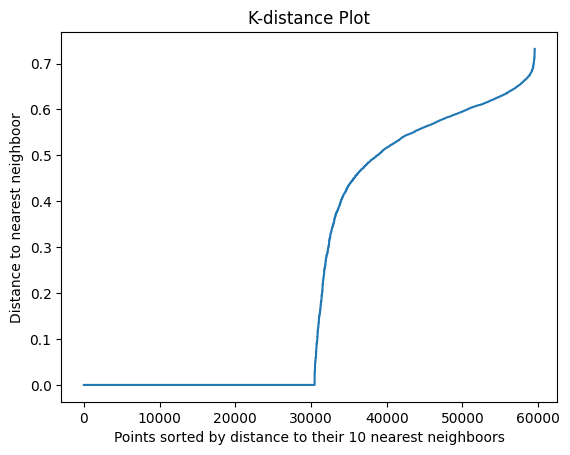

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from src.NearestNeighbours import NearestNeighbours

# This approach uses our implementation of NearestNeighbours and takes 3 min

k_nearest_neigbours = 15
all_distances = []

nearest_neighbours = NearestNeighbours(k_nearest_neigbours).fit(features)
for i in range(len(features)):
    all_distances.append(nearest_neighbours.get_kth_nearest_neighbor_distance(i))

distances_sorted = np.sort(all_distances)

plt.plot(distances_sorted)

plt.xlabel("Points sorted by distance to their 10 nearest neighboors")
plt.ylabel("Distance to nearest neighboor")
plt.title("K-distance Plot")

plt.show()

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix

# This uses scipy and takes 15 min to run!

k_nearest_neigbours = 3
all_distances = []

all_features = np.asarray(features, dtype=np.float16)

distance_matrix_features = distance_matrix(all_features, all_features)
np.fill_diagonal(distance_matrix_features, np.inf)

k_distance = np.partition(distance_matrix_features, k_nearest_neigbours, axis=1)[:, k_nearest_neigbours]

sorted_distances = np.sort(k_distance)

plt.plot(sorted_distances)
plt.xlabel("Points sorted by distance to their 10 nearest neighboors")
plt.ylabel("Distance to nearest neighboor")
plt.title("K-distance Plot")

plt.show()


KeyboardInterrupt: 

## 3. Module 2 — Graph-Based Analysis

In [ ]:
import networkx as nx

# Build graph
G = nx.Graph()

## 4. Module 3 — Pattern / Text Mining

In [ ]:
# Pattern mining implementation
patterns = None

## 5. Final Synthesis and Reflection

- Key insights:
- Limitations:
- Revisions after feedback:
